In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import os
import time
import math

In [140]:
dataset = 'last-fm'
algorithm = 'kgat'

In [141]:
ds_path = os.path.join(os.getcwd(), f'Data/{dataset}')
embed_path = os.path.join(os.getcwd(), f'embeds/{dataset}/{algorithm}')
plot_path = os.path.join(os.getcwd(), f'plots/{dataset}')
scores_path = os.path.join(os.getcwd(), f'scores/{dataset}/{algorithm}')
results_path = os.path.join(os.getcwd(), f'results/{dataset}/{algorithm}')
print("Dataset path:", ds_path)
print("Embed path:", embed_path)
print("Plots path:", plot_path)
print("Score path:", scores_path)
print("Results path:", results_path)

Dataset path: /Users/johnhannebery/gitrepos/recsys/Data/last-fm
Embed path: /Users/johnhannebery/gitrepos/recsys/embeds/last-fm/kgat
Plots path: /Users/johnhannebery/gitrepos/recsys/plots/last-fm
Score path: /Users/johnhannebery/gitrepos/recsys/scores/last-fm/kgat
Results path: /Users/johnhannebery/gitrepos/recsys/results/last-fm/kgat


In [142]:
def _load_ratings(file_name):
    user_dict = dict()
    inter_mat = list()

    lines = open(file_name, 'r').readlines()
    for l in lines:
        tmps = l.strip()
        inters = [int(i) for i in tmps.split(' ')]

        u_id, pos_ids = inters[0], inters[1:]
        pos_ids = list(set(pos_ids))

        for i_id in pos_ids:
            inter_mat.append([u_id, i_id])

        if len(pos_ids) > 0:
            user_dict[u_id] = pos_ids
    return np.array(inter_mat), user_dict

In [143]:
train, train_user_dict = _load_ratings(os.path.join(ds_path,'train.txt'))
test, test_user_dict = _load_ratings(os.path.join(ds_path,'test.txt'))

In [144]:
cols = ['user_id', 'item_id']
train = pd.DataFrame(train, columns = cols)
test = pd.DataFrame(test, columns = cols)

In [145]:
test = test[test['user_id'].isin(train['user_id'].tolist())]
test = test[test['item_id'].isin(train['item_id'].tolist())]

In [146]:
user_embed = pd.read_csv(os.path.join(embed_path,'user_embed.csv'))
if algorithm == 'kgat':
    item_embed = pd.read_csv(os.path.join(embed_path,'entity_embed.csv'))
else:
    item_embed = pd.read_csv(os.path.join(embed_path,'item_embed.csv'))

In [147]:
#read scores
scores_df = pd.read_csv(os.path.join(scores_path,'scores_df.csv'))

In [148]:
#Split into high and low activity groups
user_counts_data = train.groupby('user_id',as_index=False).agg({'item_id':'count'}).rename(columns={'item_id':'count'})
item_counts_data = train.groupby('item_id',as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'count'})

user_cutoff = user_counts_data['count'].quantile(0.8)
print(user_cutoff)

item_cutoff = item_counts_data['count'].quantile(0.8)
print(item_cutoff)

user_low_activity = user_counts_data[user_counts_data['count'] <= user_cutoff]['user_id'].tolist()

item_low_activity = item_counts_data[item_counts_data['count'] <= item_cutoff]['item_id'].tolist()

user_low_activity_test = test[test['user_id'].isin(user_low_activity)]
user_high_activity_test = test[~test['user_id'].isin(user_low_activity)]

item_low_activity_test = test[test['user_id'].isin(item_low_activity)]
item_high_activity_test = test[~test['user_id'].isin(item_low_activity)]

75.0
35.0


In [149]:
user_plot_cutoff = user_counts_data['count'].quantile(0.99)
item_plot_cutoff = item_counts_data['count'].quantile(0.99)

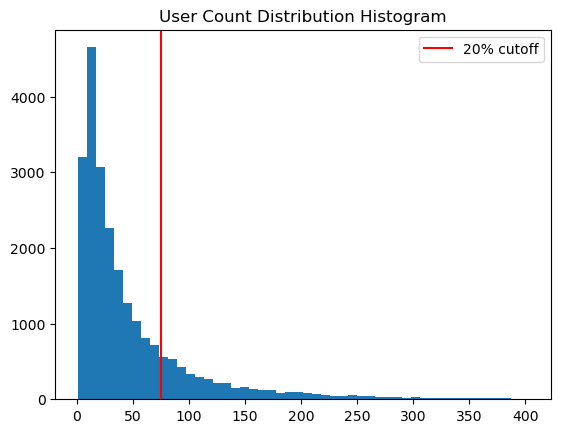

In [150]:
plt.hist(user_counts_data[user_counts_data['count']<= user_plot_cutoff]['count'], bins=50)
plt.axvline(x=user_cutoff, color='red', label='20% cutoff')
plt.legend()
plt.title("User Count Distribution Histogram")
plt.savefig(os.path.join(plot_path, 'user_dist'))

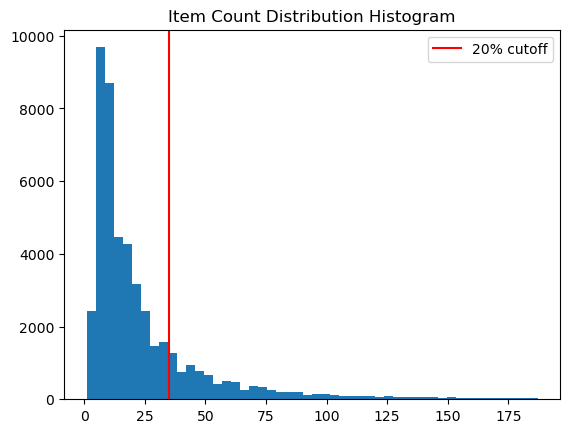

In [151]:
plt.hist(item_counts_data[item_counts_data['count']<= item_plot_cutoff]['count'], bins=50)
plt.axvline(x=item_cutoff, color='red', label='20% cutoff')
plt.legend()
plt.title("Item Count Distribution Histogram")
plt.savefig(os.path.join(plot_path, 'item_dist'))

Load results

In [152]:
all_users = pd.read_csv(os.path.join(results_path,'results_all.csv'), index_col='Unnamed: 0')
all_users['group']='all'

low_users = pd.read_csv(os.path.join(results_path,'results_low_user.csv'), index_col='Unnamed: 0')
low_users['group']='low'

high_users = pd.read_csv(os.path.join(results_path,'results_high_user.csv'), index_col='Unnamed: 0')
high_users['group']='high'

low_items = pd.read_csv(os.path.join(results_path,'results_low_item.csv'), index_col='Unnamed: 0')
low_items['group']='low'

high_items = pd.read_csv(os.path.join(results_path,'results_high_item.csv'), index_col='Unnamed: 0')
high_items['group']='high'

In [153]:
user_results = pd.concat([all_users, low_users, high_users])
item_results = pd.concat([all_users, low_items, high_items])

In [154]:
user_results

,precision,recall,ndcg,hit_ratio,F1,diversity,novelty,coverage,K,group
0,0.077824,0.011263,0.077824,0.077824,0.017576,1.000000,8.373490,0.161603,1,all
1,0.068548,0.045416,0.114664,0.234024,0.044413,4.151016,8.386515,0.409920,5,all
2,0.061389,0.077626,0.159066,0.343970,0.054898,4.273278,8.396583,0.561196,10,all
3,0.052257,0.122073,0.219463,0.469448,0.059269,4.417455,8.413675,0.707277,20,all
0,0.077196,0.013619,0.077196,0.077196,0.021089,1.000000,8.383351,0.144564,1,low
1,0.065968,0.054514,0.112892,0.224180,0.051668,4.117731,8.395614,0.382886,5,low
2,0.058365,0.092857,0.155530,0.329101,0.062282,4.247183,8.403577,0.533414,10,low
3,0.048220,0.144877,0.210729,0.448519,0.064354,4.400196,8.419326,0.683858,20,low
0,0.080369,0.001720,0.080369,0.080369,0.003347,1.000000,8.333548,0.054069,1,high
1,0.078997,0.008563,0.121842,0.273896,0.015029,4.285843,8.349659,0.164429,5,high


In [155]:
def metricplots(stats_df, user_or_item):
    for K in stats_df['K'].unique().tolist():
        for metric in stats_df.columns.drop(['K','group']).tolist():
            stats_df[stats_df['K']==K].pivot(index=None, columns='group', values=metric).plot(kind='bar')
            plt.title(f'{user_or_item}_{metric}@{K}')
            plt.savefig(os.path.join(plot_path, algorithm, f'{user_or_item}_{metric}@{K}'))

/opt/anaconda3/envs/tf_m1/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


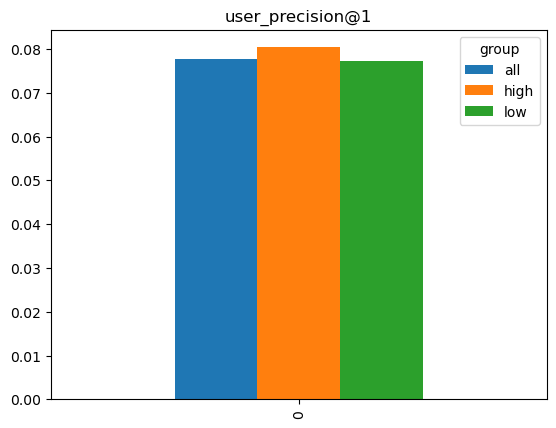

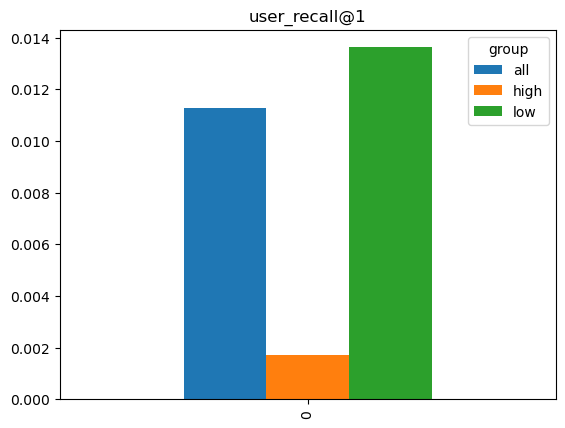

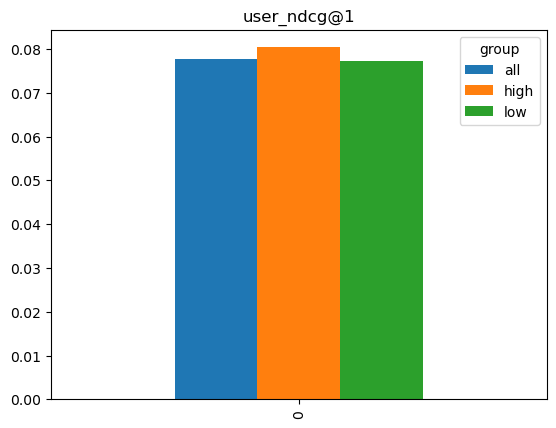

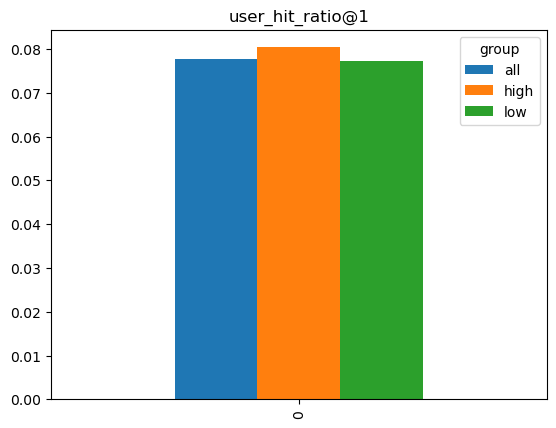

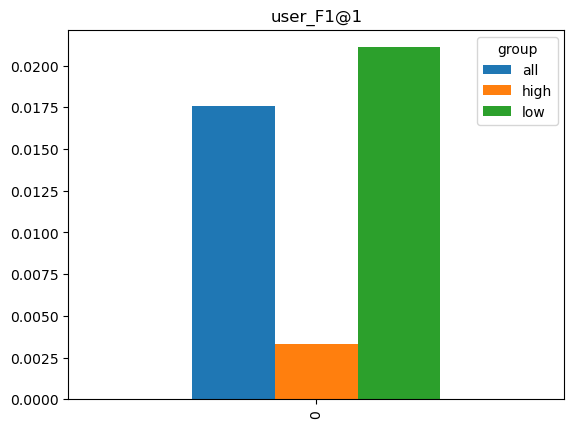

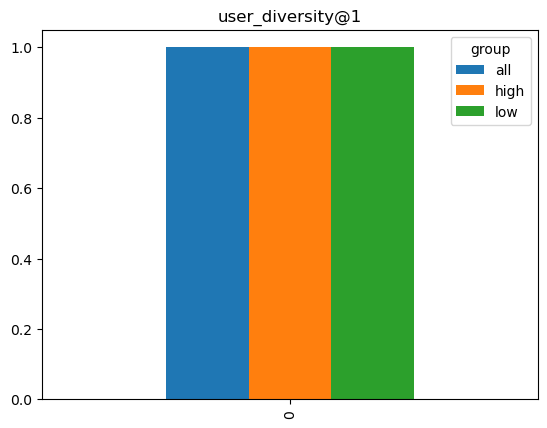

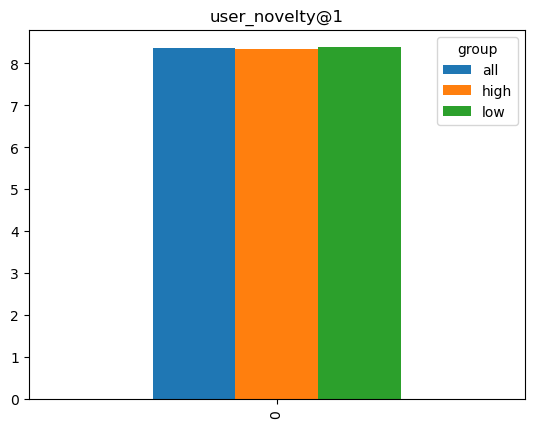

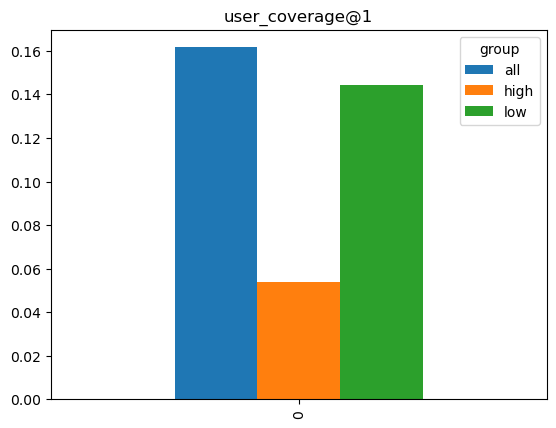

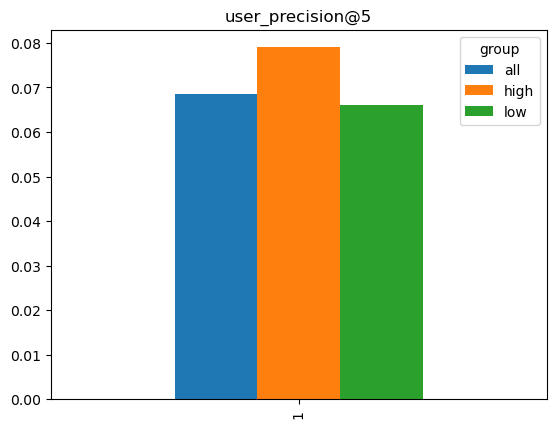

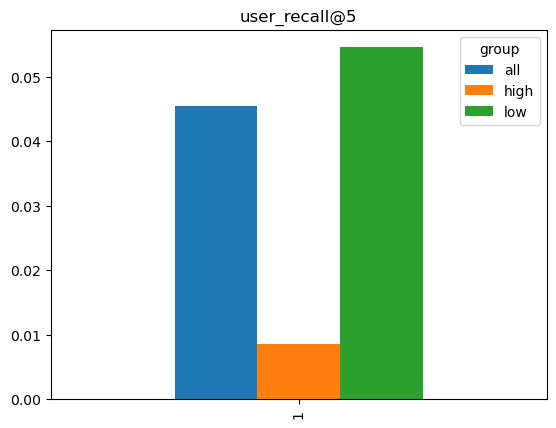

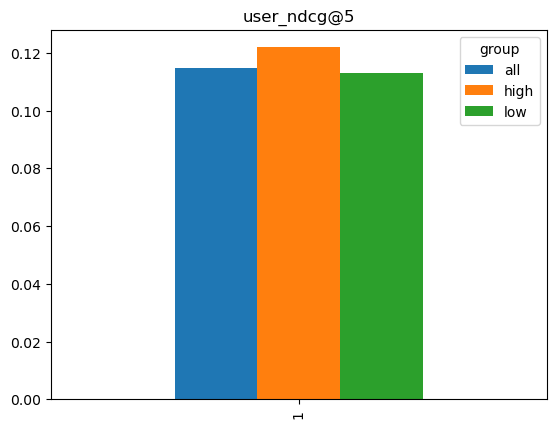

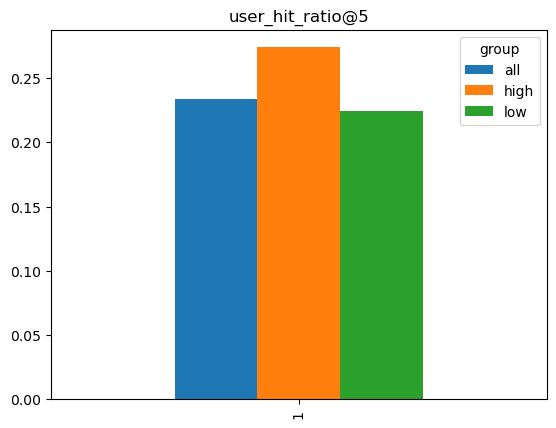

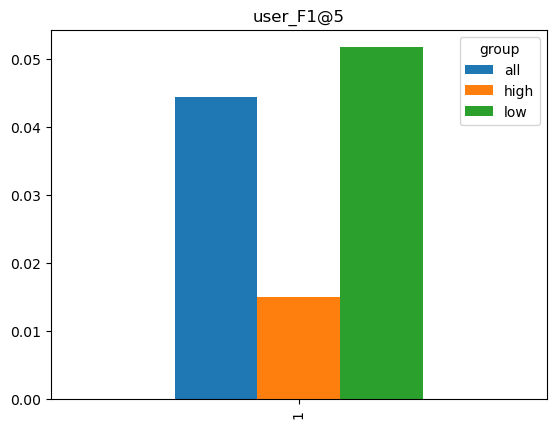

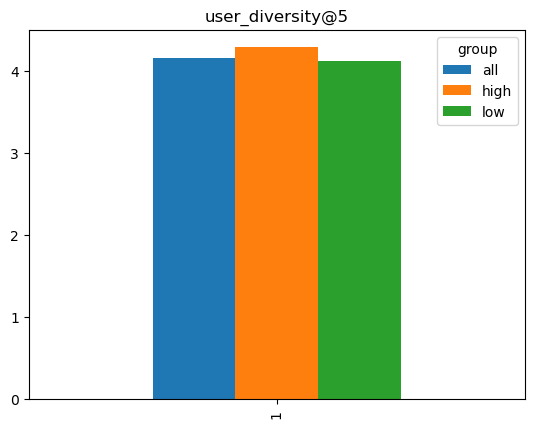

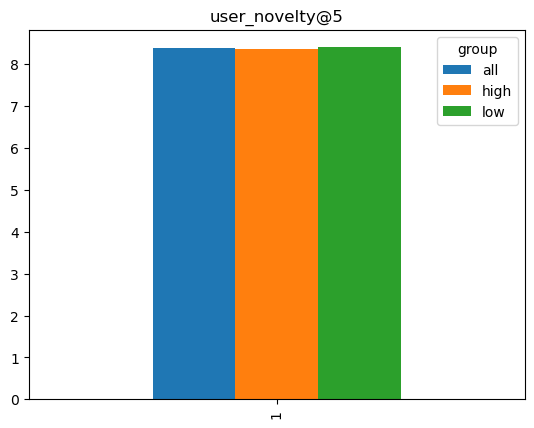

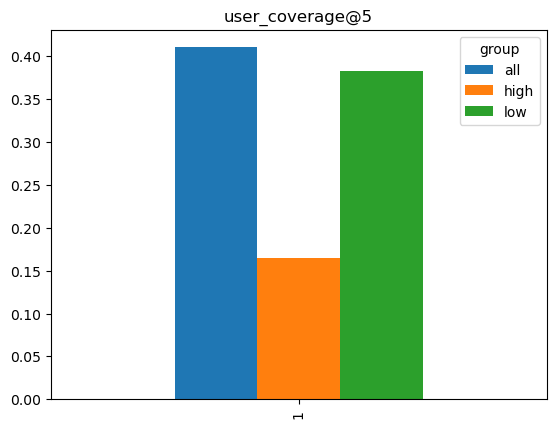

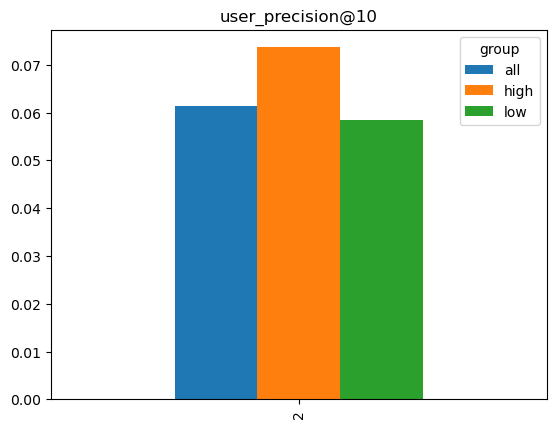

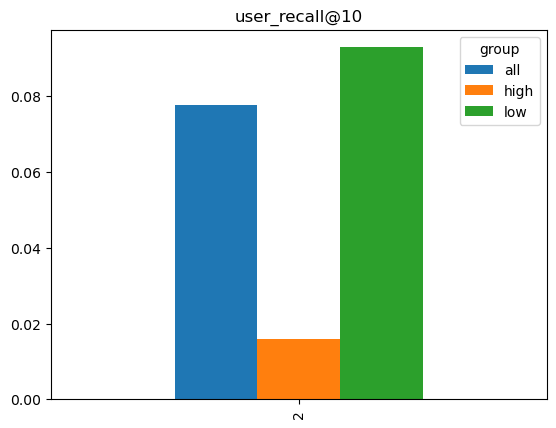

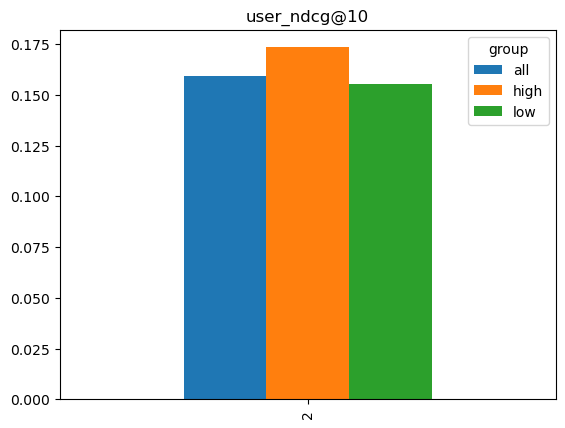

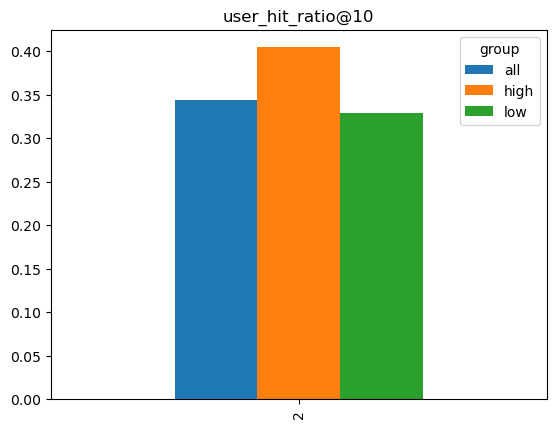

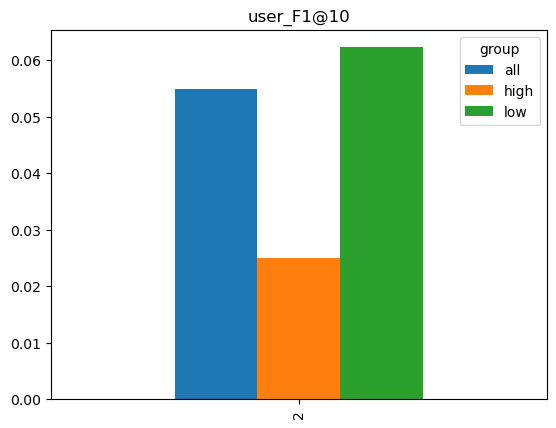

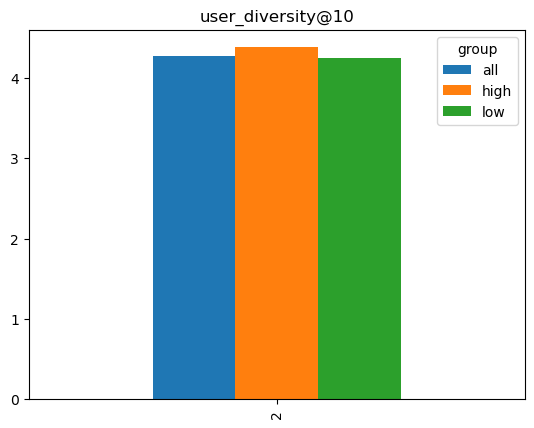

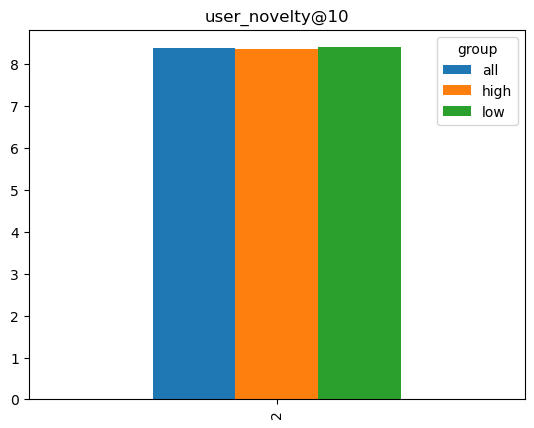

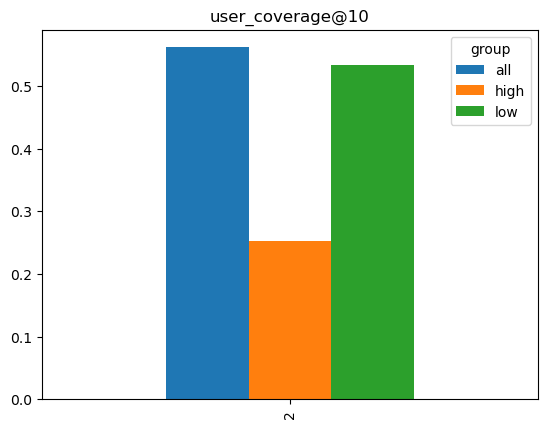

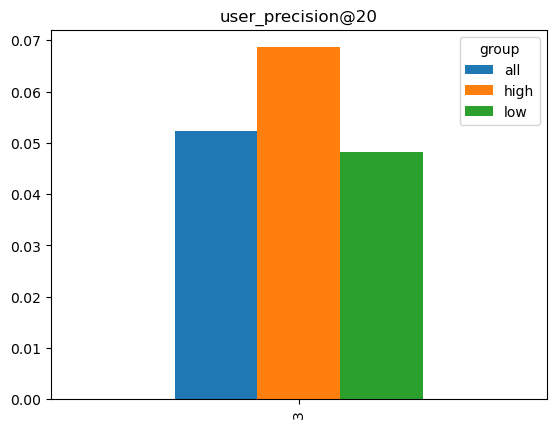

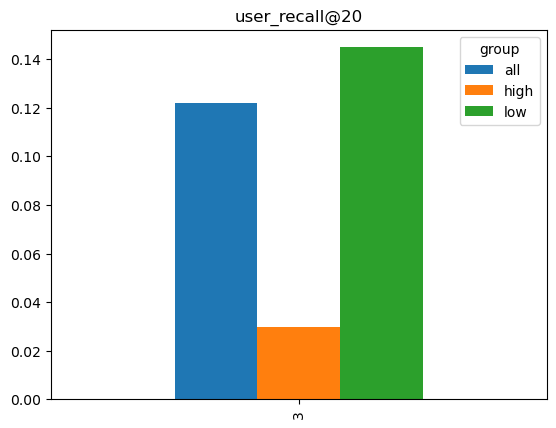

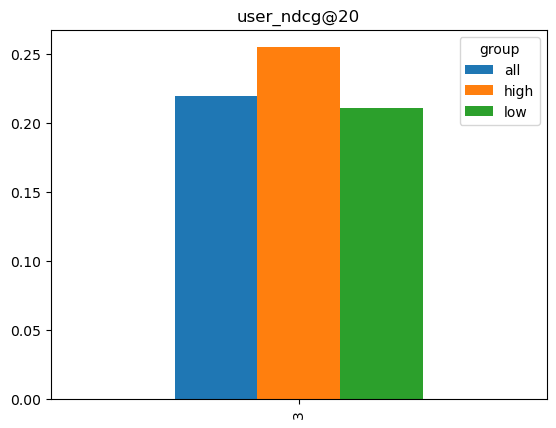

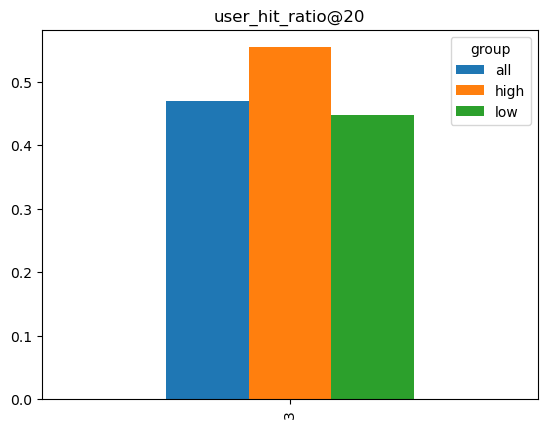

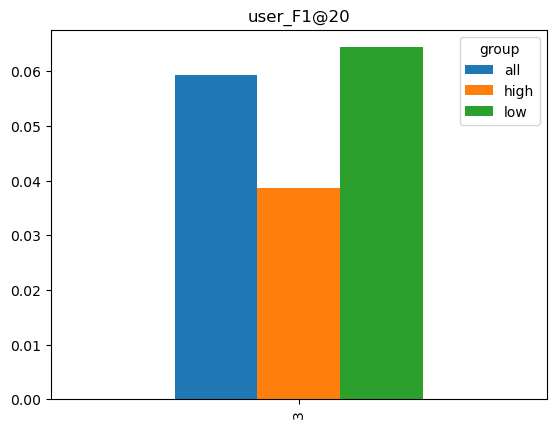

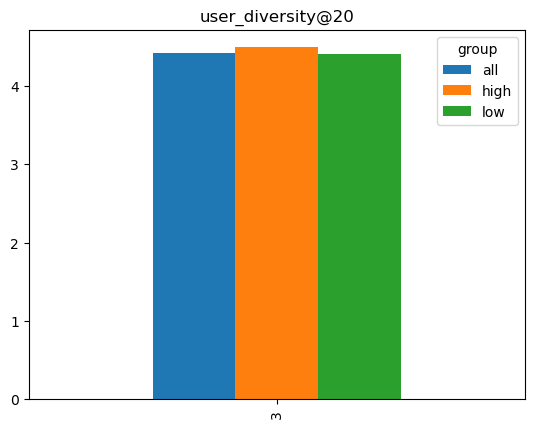

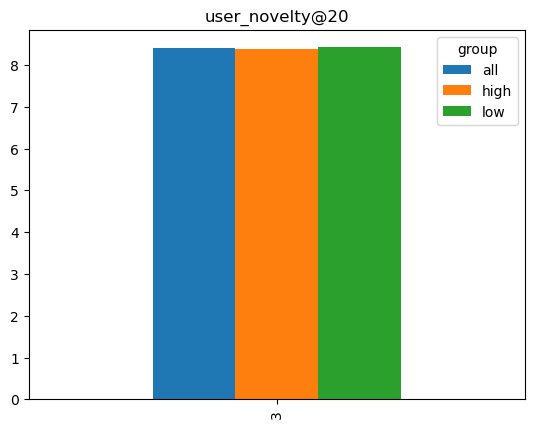

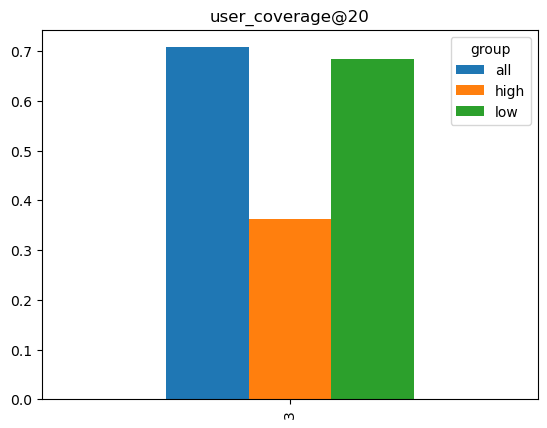

In [156]:
metricplots(user_results, 'user')

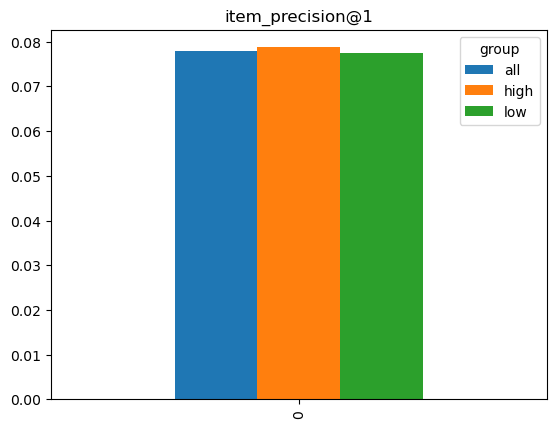

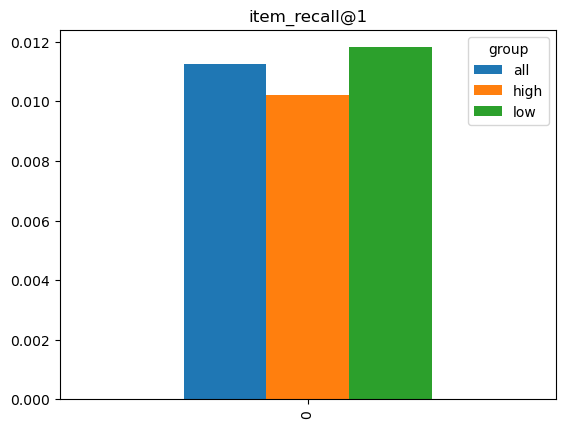

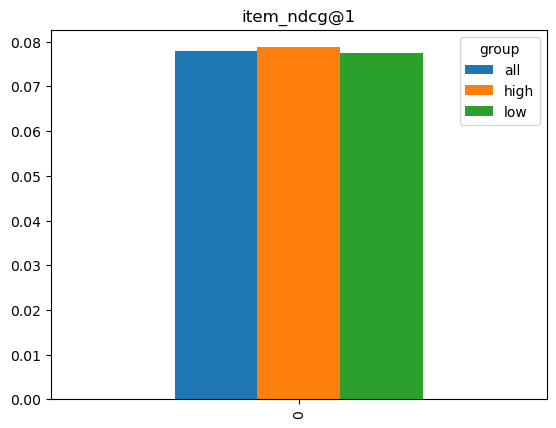

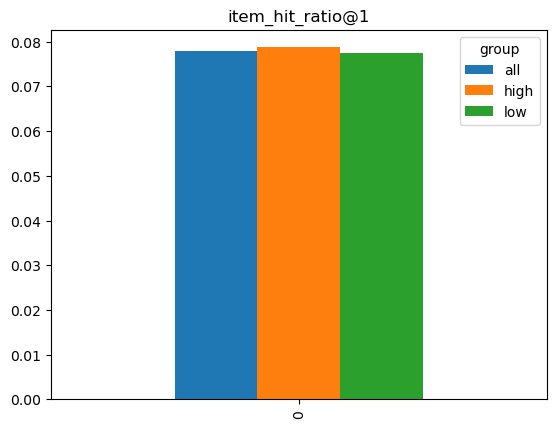

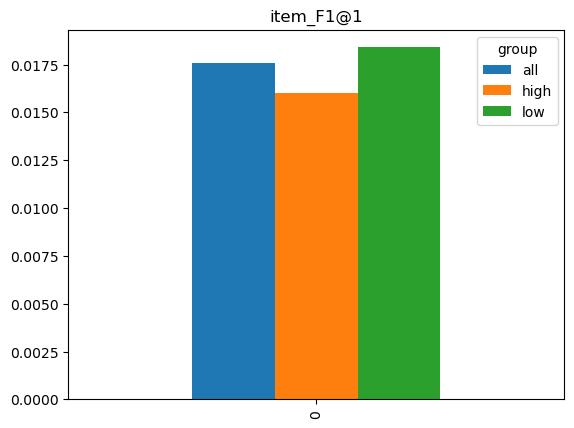

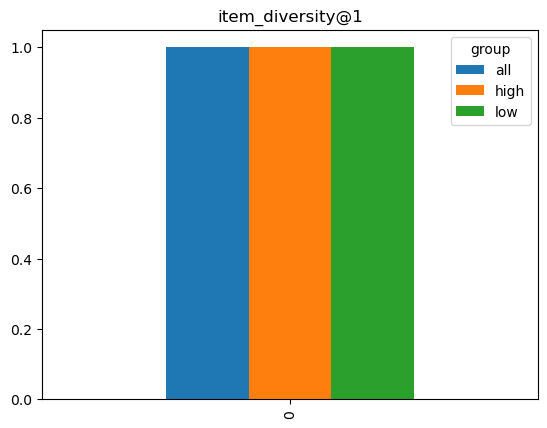

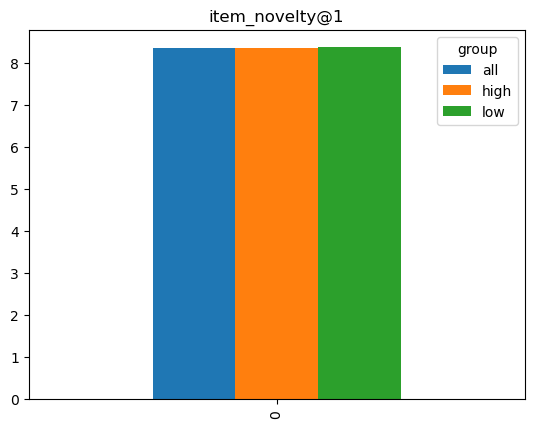

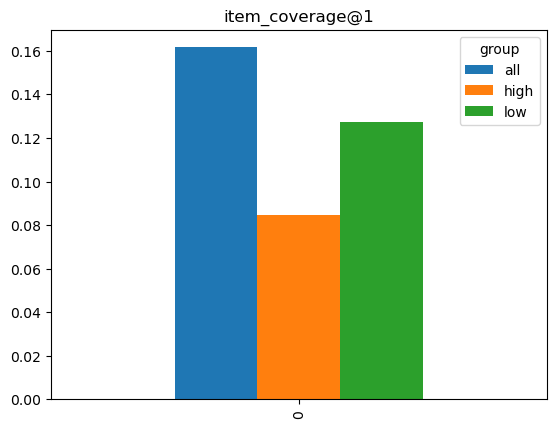

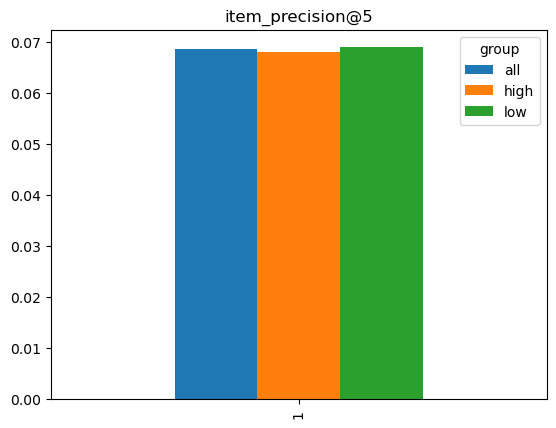

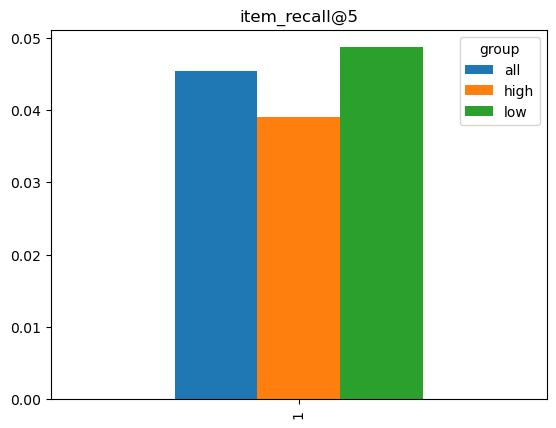

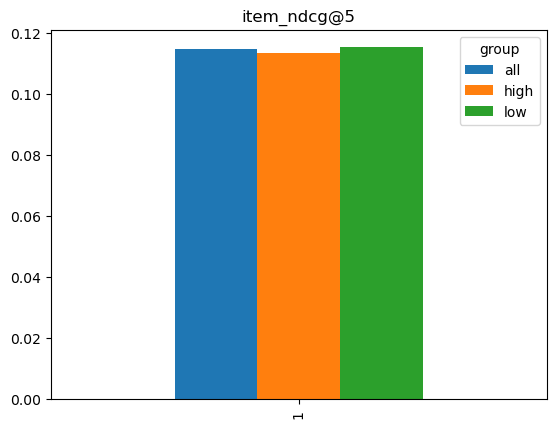

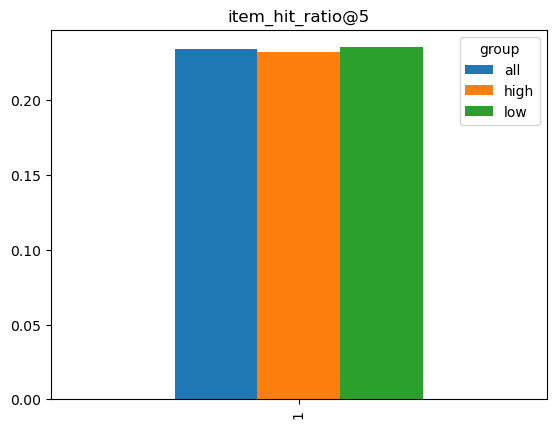

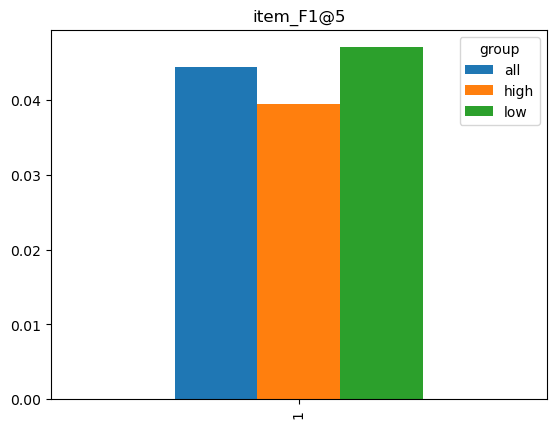

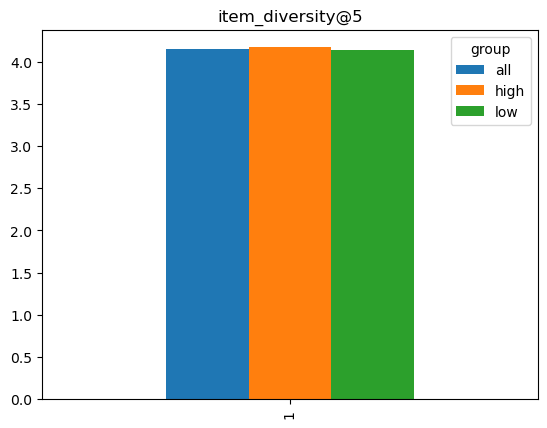

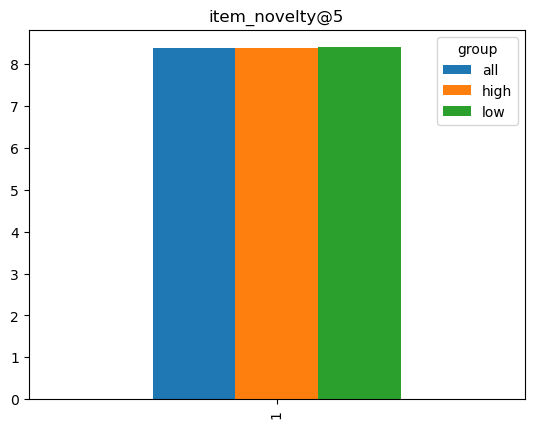

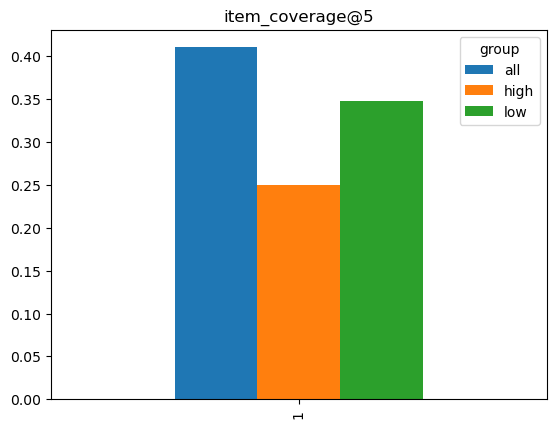

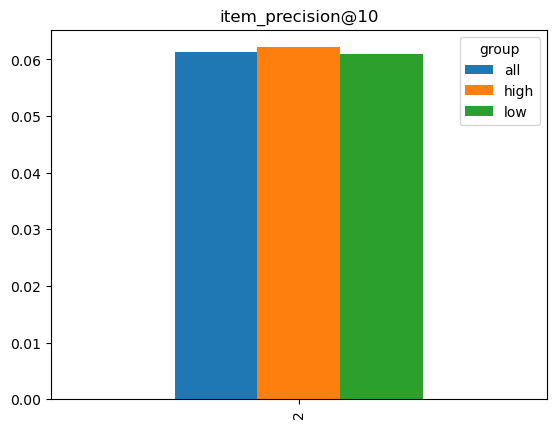

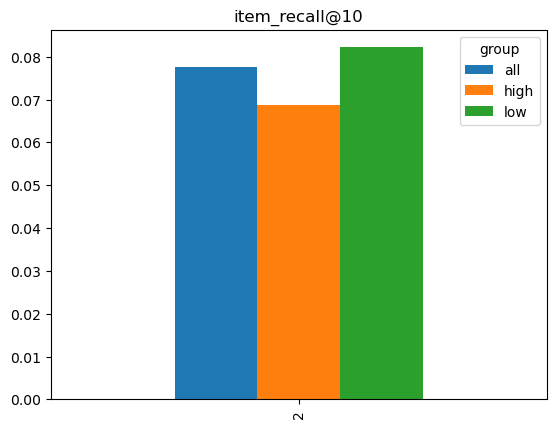

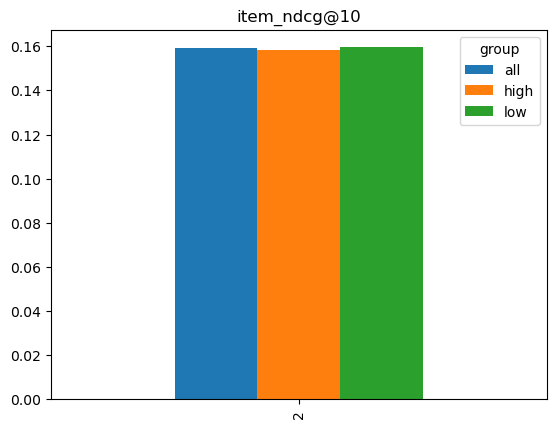

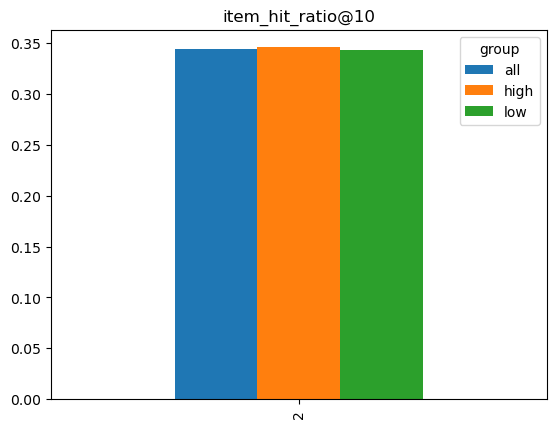

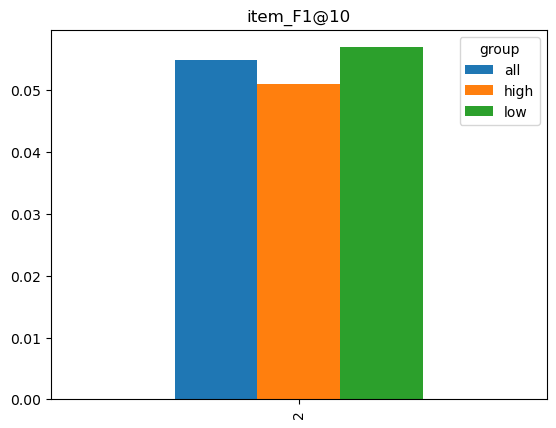

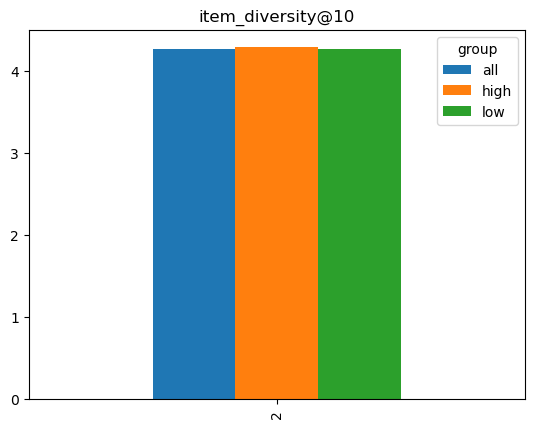

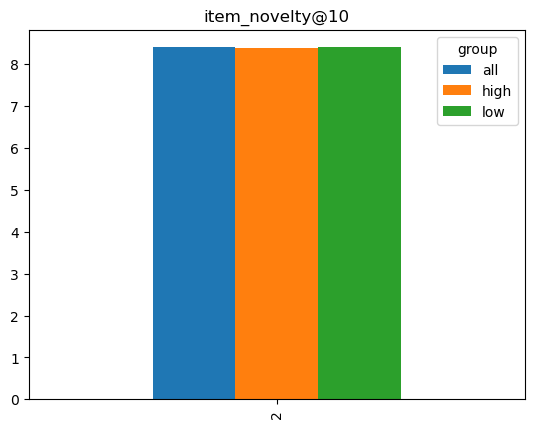

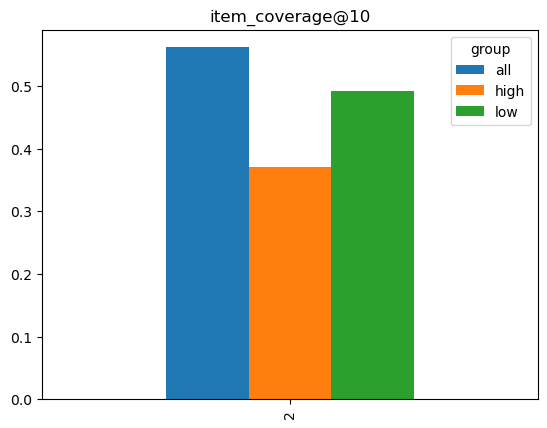

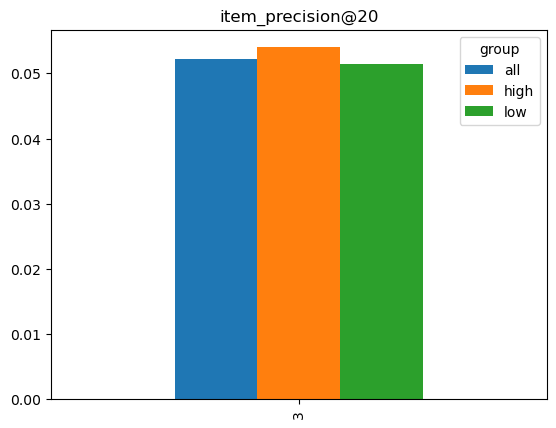

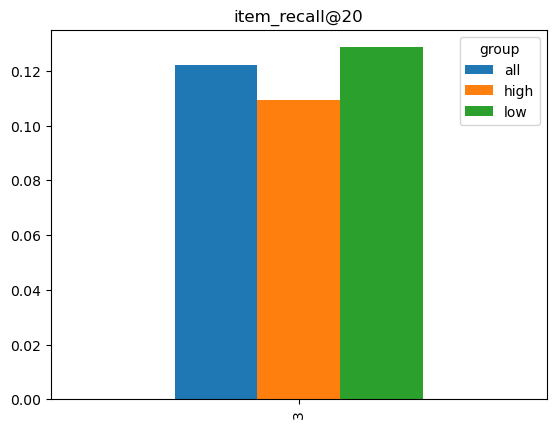

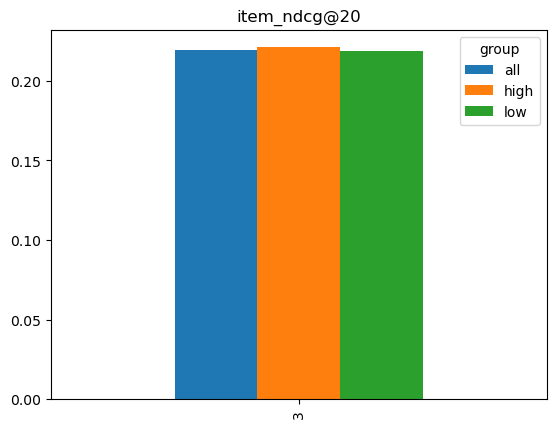

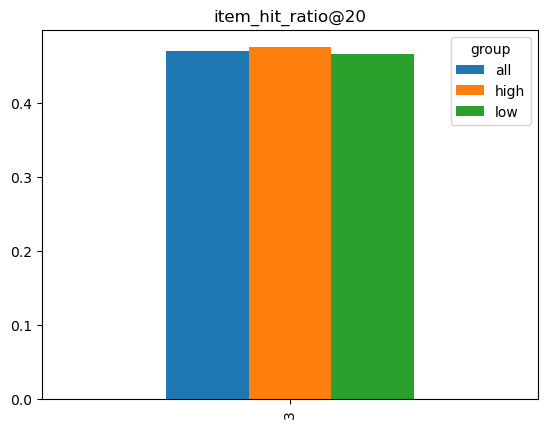

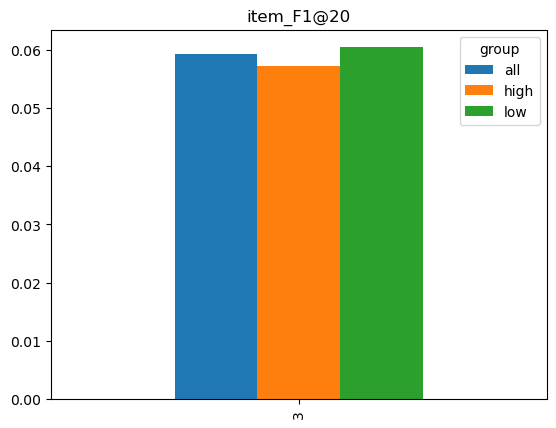

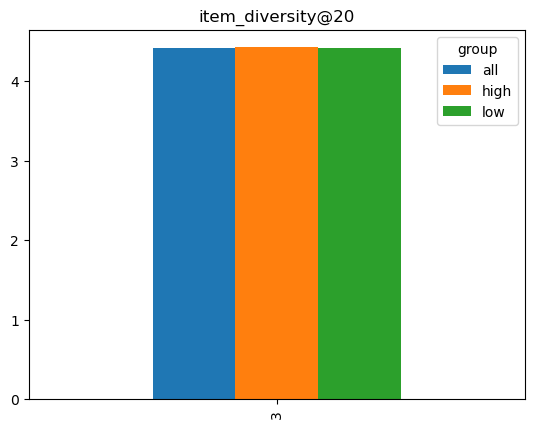

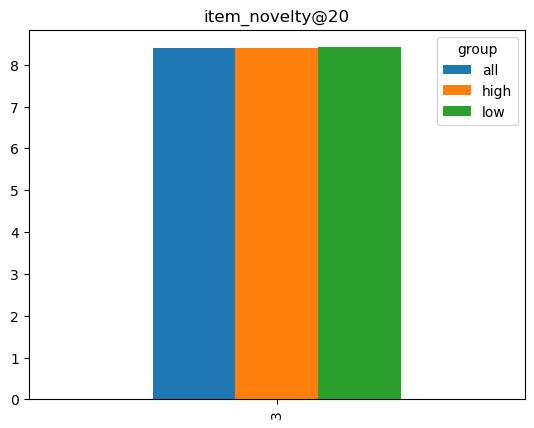

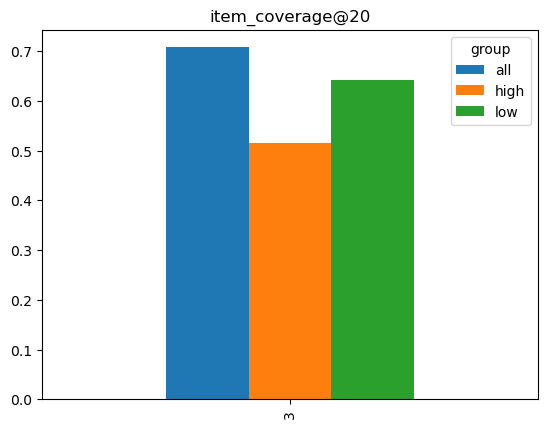

In [157]:
metricplots(item_results, 'item')

In [158]:
def get_fair_metrics(stats_df):
    li=[]
    for K in stats_df['K'].unique().tolist():
        for metric in stats_df.columns.drop(['K','group']).tolist():
            low = stats_df[(stats_df['group']=='low') & (stats_df['K']==K)][metric].iloc[0]
            high = stats_df[(stats_df['group']=='high') & (stats_df['K']==K) ][metric].iloc[0]
            fairness_score = np.round((high-low)/low, 3)
            li.append([metric, K, fairness_score])
            fairdf = pd.DataFrame(li,columns=['metric','K','fairness'])
            
    return fairdf

In [159]:
fairness_user_df = get_fair_metrics(user_results)
fairness_item_df = get_fair_metrics(item_results)

In [160]:
fairness_user_df.to_csv(os.path.join(results_path, 'user_fairness.csv'))
fairness_item_df.to_csv(os.path.join(results_path, 'item_fairness.csv'))